## Lowest index of ciphersuites containing weak/insecure algorithms

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm
import sqlite3
import time
import hashlib
import re
import datetime
import matplotlib.pyplot as plt
import matplotlib
import editdistance
import functools
from IPython.display import clear_output
import seaborn as sns
import random
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

### Readin dataset

In [2]:
alldf = pd.read_csv("../datasets/2014dev_fps.csv")

### Readin ciphersuite mapping info: map ciphersuite in code to human-readable format

In [4]:
cipher_map = pd.read_csv("../datasets/ciphersuite_map.csv").rename(columns={"cipher_x": "ciphersuite"})

In [5]:
cipher_map.sample(2)

,ciphersuite,count,code_1sthalf,code_2ndhalf,code,cipher_y,dtls_ok,recommended,ref,key_exchange,mac,cipher,code_base10
119,0xc073,98,0xc0,0x73,"0xc0,0x73",TLS_ECDHE_ECDSA_WITH_CAMELLIA_256_CBC_SHA384,Y,N,[RFC6367],tls_ecdhe_ecdsa,sha384,camellia_256_cbc,49267
259,0xc066,2,0xc0,0x66,"0xc0,0x66",TLS_DHE_PSK_WITH_ARIA_128_CBC_SHA256,Y,N,[RFC6209],tls_dhe_psk,sha256,aria_128_cbc,49254


### Algorithms of different security level

In [6]:
secure_lis = ['dhe_rsa', 'dhe_dss', 'dhe_psk', 'ecdhe_psk', 'ecdhe_ecdsa', \
              'aes_128_gcm', 'aes_256_gcm', 'aes_128_ccm_8', 'aes_256_ccm_8', 'aes_128_ccm', 'aes_256_ccm', \
              'camellia_128_gcm', 'camellia_256_gcm', 'aria_128_gcm', 'aria_256_gcm', 'chacha20_poly1305', \
              'sha256', 'sha384', \
              'fallback', 'secure_renego', '13', 'secure_renego', 'fallback_scsv', 'scsv']
weak_lis = ['rsa', 'ecdh_rsa', 'ecdh_ecdsa', 'dh_rsa', 'psk', 'dh_dss', 'krb5', 'srp_sha_rsa', 'srp_sha_dss', 'srp_sha', \
            'aes_128_cbc', 'aes_256_cbc', '3des_ede_cbc', 'camellia_128_cbc', 'camellia_256_cbc', 'aria_128_cbc', 'aria_256_cbc', \
            'seed_cbc', 'idea_cbc', 'sha']
insecure_lis = ['dh_anon', 'krb5_export', 'ecdh_anon', 'null', 'rc4_128', 'rc4_40', 'rc2_cbc_40', 'des_cbc', 'des40_cbc', \
                'des_cbc_40', 'md5']

### Helper functions

In [7]:
def pos_estimating(text1, text2, text3):
    if text2 == "missing":
        return 'insecure'
    
    ans1 = secure_level_estimating(text1.split("tls_")[-1])
    ans2 = secure_level_estimating(text2)
    ans3 = secure_level_estimating(text3)
    
    comp_lis = [ans1, ans2, ans3]
    
    secure_cnt = comp_lis.count('secure')
    weak_cnt = comp_lis.count('weak')
    insecure_cnt = comp_lis.count('insecure')
    
    if secure_cnt == 3:
        return 'secure'
    elif insecure_cnt > 0 :
        return 'insecure'
    elif weak_cnt == 1:
        return 'weak1'
    elif weak_cnt == 2:
        return 'weak2'
    elif weak_cnt == 3:
        return 'weak3'

In [8]:
def estscore_assigning(est):
    if est == "secure":
        return 1
    elif est == "weak1":
        return 0.5
    elif est == "weak2":
        return 0.25
    elif est == "weak3":
        return 0.125
    elif est == "insecure":
        return 0

In [9]:
first_weight = 1
second_weight = 0.3
third_weight = 0.1
other_weight = 0.01

In [10]:
def score_estimating(est_lis):
    score = 0
    lis_len = len(est_lis)
    
    if lis_len == 1:
        est1 = estscore_assigning(est_lis[0])
        score = (first_weight * est1) / (first_weight)
    elif lis_len == 2:
        est1 = estscore_assigning(est_lis[0])
        est2 = estscore_assigning(est_lis[-1])
        score = (first_weight * est1 + second_weight * est2) / (first_weight + second_weight)
    elif lis_len == 3:
        est1 = estscore_assigning(est_lis[0])
        est2 = estscore_assigning(est_lis[1])
        est3 = estscore_assigning(est_lis[-1])
        score = (first_weight * est1 + second_weight * est2 + third_weight * est3) / (first_weight + second_weight + third_weight)
    elif lis_len >= 4 and lis_len <= 10:
        est1 = estscore_assigning(est_lis[0])
        est2 = estscore_assigning(est_lis[1])
        est3 = estscore_assigning(est_lis[2])
        score = first_weight * est1 + second_weight * est2 + third_weight * est3
        for cipher in est_lis[3:]:
            score += estscore_assigning(cipher) * other_weight
        score /= (first_weight + second_weight + third_weight + (lis_len - 3) * other_weight)
    elif lis_len > 10:
        est1 = estscore_assigning(est_lis[0])
        est2 = estscore_assigning(est_lis[1])
        est3 = estscore_assigning(est_lis[2])
        score = first_weight * est1 + second_weight * est2 + third_weight * est3
        for cipher in est_lis[3:10]:
            score += estscore_assigning(cipher) * other_weight
        score /= (first_weight + second_weight + third_weight + (10 - 3) * other_weight)
        
    return score

In [11]:
def pos_assigning(code_lis):
    est_lis = []
    codelis_eval = eval(code_lis)
    for ciphercode in codelis_eval:
        cipher_base10 = int(ciphercode)
        if cipher_base10 in secure_code_lis:
            est_lis.append("secure")
        elif cipher_base10 in weak1_code_lis:
            est_lis.append("weak1")
        elif cipher_base10 in weak2_code_lis:
            est_lis.append("weak2")
        elif cipher_base10 in weak3_code_lis:
            est_lis.append("weak3")
        elif cipher_base10 in insecure_lis:
            est_lis.append("insecure")
    return est_lis

In [12]:
def secure_level_estimating(text):
    if text in secure_lis:
        return "secure"
    elif text in weak_lis:
        return "weak"
    elif text in insecure_lis:
        return "insecure"

In [13]:
def getting_lowest_notsecure(est_lis):
    lowest_notsecure = -1
    for idx, val in enumerate(est_lis):
        if val == "weak1" or val == "weak2" or val == "weak3" or val == "insecure":
            lowest_notsecure = idx + 1
            break
    return lowest_notsecure        

### Process dataframe

In [14]:
cipher_map['cipher'] = cipher_map['cipher'].fillna("missing")

#### Split ciphersuites into components

In [15]:
cipher_map['pos_est'] = cipher_map.apply(lambda x: pos_estimating(x['key_exchange'], x['cipher'], x['mac']), axis=1)

In [16]:
cipher_map['code_base10'] = cipher_map['ciphersuite'].apply(lambda x: int(x, 16))

In [17]:
cipher_map.sample(2)

,ciphersuite,count,code_1sthalf,code_2ndhalf,code,cipher_y,dtls_ok,recommended,ref,key_exchange,mac,cipher,code_base10,pos_est
305,0xc055,2,0xc0,0x55,"0xc0,0x55",TLS_DH_RSA_WITH_ARIA_256_GCM_SHA384,Y,N,[RFC6209],tls_dh_rsa,sha384,aria_256_gcm,49237,weak1
328,0xc069,1,0xc0,0x69,"0xc0,0x69",TLS_RSA_PSK_WITH_ARIA_256_CBC_SHA384,Y,N,[RFC6209],tls_rsa,sha384,aria_256_cbc,49257,weak2


In [18]:
secure_code_lis = cipher_map.loc[cipher_map['pos_est'] == "secure"]['code_base10'].tolist()
weak1_code_lis = cipher_map.loc[cipher_map['pos_est'] == "weak1"]['code_base10'].tolist()
weak2_code_lis = cipher_map.loc[cipher_map['pos_est'] == "weak2"]['code_base10'].tolist()
weak3_code_lis = cipher_map.loc[cipher_map['pos_est'] == "weak3"]['code_base10'].tolist()
insecure_code_lis = cipher_map.loc[cipher_map['pos_est'] == 'insecure']['code_base10'].tolist()

#### Calculating lowest index

In [19]:
alldf['cipher_est'] = alldf['cipher_code'].apply(lambda x: pos_assigning(x))

In [20]:
alldf['lowest_notsecure'] = alldf['cipher_est'].apply(lambda x: getting_lowest_notsecure(x))

In [21]:
alldf.sample(1)

,device_id,cipher_suites,extension_types,tls_version,device_vendor,device_name,library_version,cipher_code,ciphersuite_len,cipher_code_idxl,cipher_est,lowest_notsecure
11070,sf64e9f6141,4867+4865+4866+52393+52392+49195+49199+49196+49200+49171+49172+156+157+47+53+10,23+65281+10+11+35+16+5+13+18+51+45+43+27+41,771,google,assistant,NaN,"['4867', '4865', '4866', '52393', '52392', '49195', '49199', '49196', '49200', '49171', '49172', '156', '157', '47', '53', '10']",16,"['4867:0', '4865:1', '4866:2', '52393:3', '52392:4', '49195:5', '49199:6', '49196:7', '49200:8', '49171:9', '49172:10', '156:11', '157:12', '47:13', '53:14', '10:15']","[secure, secure, secure, secure, secure, secure, secure, secure, secure, weak2, weak2, weak1, weak1, weak3, weak3, weak3]",10


#### Drop records with unknown devices

In [22]:
alldf_known = alldf.loc[alldf['device_vendor'] != 'unknown']

In [23]:
alldf_sub = alldf_known.loc[alldf_known['lowest_notsecure'] != -1]

In [24]:
alldf_sub.shape

(11046, 12)

#### Process dataframe for plotting

In [25]:
alldf_groupby_idx = alldf_known.groupby(['device_vendor', 'lowest_notsecure'])['device_id'].agg('count').reset_index(name='count')

In [26]:
def mapping_y(y_orig):
    if y_orig <= 5:
        return 10**y_orig
    else:
        n = y_orig // 5
        m = y_orig % 5
        return (10 ** (4 + n)) * (1 + 9 * m / 5)

In [27]:
alldf_sub['y_plot'] = alldf_sub['lowest_notsecure'].apply(lambda x: mapping_y(x))

<ipython-input-27-3089aba1b498>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldf_sub['y_plot'] = alldf_sub['lowest_notsecure'].apply(lambda x: mapping_y(x))


In [28]:
alldf_drop = alldf_sub.drop_duplicates(subset=['device_id', 'cipher_suites'])

In [29]:
alldf_devcnt = alldf.groupby(['device_vendor'])['device_id'].agg('count').reset_index(name='dev_cnt')

In [30]:
alldf_devcnt.shape

(66, 2)

In [31]:
alldf_withdevcnt = pd.merge(alldf_drop, alldf_devcnt, how='left', on='device_vendor')

In [32]:
alldf_withdevcnt['device_vendor'] = alldf_withdevcnt['device_vendor'].apply(lambda x: x.capitalize())

In [33]:
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Lg')] = 'LG'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Directv')] = 'DirecTV'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Dish network')] = 'Dish Network'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Tcl')] = 'TCL'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Tplink')] = 'TP-Link'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Western digital')] = 'Western Digital'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Hp')] = 'HP'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Ihome')] = 'iHome'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Ikea')] = 'IKEA'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Irobot')] = 'iRobot'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Netgear')] = 'NETGEAR'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Qnap')] = 'QNAP'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Sleep number')] = 'Sleep Number'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Echobee')] = 'echobee'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Idevices')] = 'iDevices'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Vmware')] = 'VMware'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Hdhomerun')] = 'HDHomeRun'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Ecobee')] = 'ecobee'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Texas instruments')] = 'Texas Instruments'

<ipython-input-33-3f55d79277db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Lg')] = 'LG'
<ipython-input-33-3f55d79277db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Directv')] = 'DirecTV'
<ipython-input-33-3f55d79277db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  al

In [34]:
alldf_withdevcnt['device_vendor_withcnt'] = alldf_withdevcnt.apply(lambda x: x['device_vendor'] + " (" + str(x['dev_cnt']) + ")", axis=1)

In [35]:
grouped_lowest_idx = alldf_withdevcnt.groupby('device_vendor_withcnt')
lowestidx_sorted_mean = (
    pd.DataFrame({col: vals['y_plot'] for col, vals in grouped_lowest_idx})
    .mean()
    .sort_values(ascending=False)
)

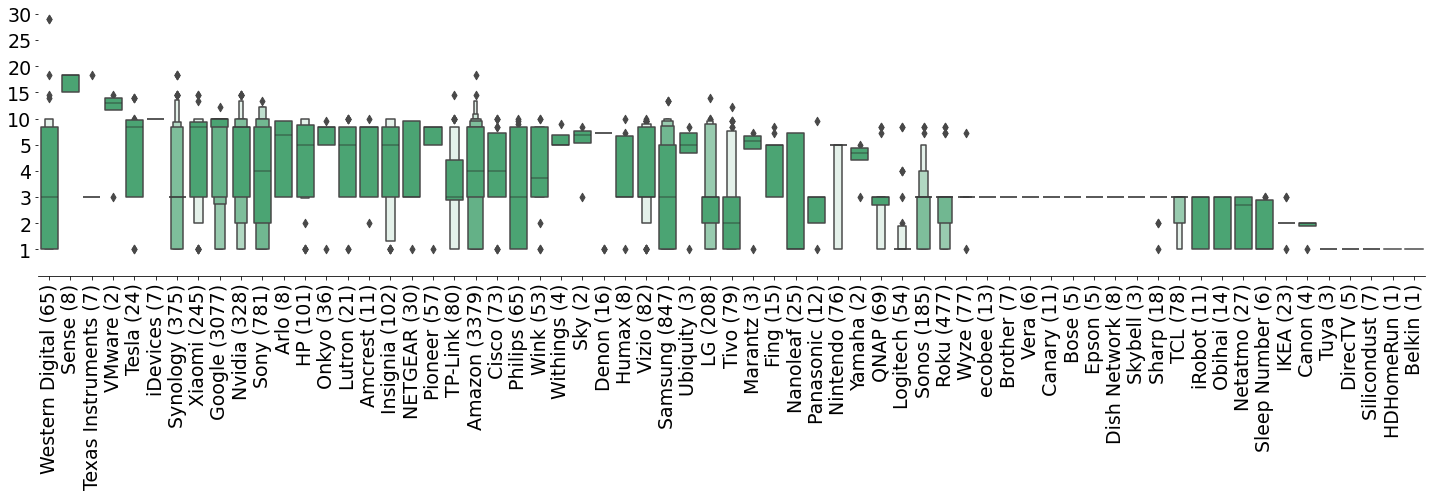

In [36]:
fig = plt.subplots(figsize=(20, 7))
sns.despine(right=True, left=True)

ax = sns.boxenplot(x='device_vendor_withcnt', y='y_plot', data=alldf_withdevcnt, color='mediumseagreen', \
                   scale='linear', showfliers=True, order=lowestidx_sorted_mean.index)

plt.ylim(10**0, 10**10)
#ax.invert_yaxis()
#ax.get_legend().remove()
plt.ylabel("")
plt.xlabel("")
plt.yscale('log')
plt.yticks([10, 100, 1000, 10**4,10**5,10**6,10**7,10**8,10**9, 10**10],labels=[1,2,3,4,5,10,15,20,25,30],fontsize=19)
plt.xticks(rotation=90, fontsize=19)

#ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14.5, ha='center', va='top')
#ax.tick_params(axis="y",direction="out", pad=10)
#ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, va='center')

plt.tight_layout()
plt.show()

## Position-based scoring

In [37]:
alldf.sample(1)

,device_id,cipher_suites,extension_types,tls_version,device_vendor,device_name,library_version,cipher_code,ciphersuite_len,cipher_code_idxl,cipher_est,lowest_notsecure
3304,s40d6448bbb,49172+49162+57+56+55+54+49167+49157+53+49171+49161+51+50+49+48+154+153+152+151+49166+49156+47+150+49169+49159+49164+49154+5+4+49170+49160+22+19+16+13+49165+49155+10+255,11+10+35+15,769,vizio,device,NaN,"['49172', '49162', '57', '56', '55', '54', '49167', '49157', '53', '49171', '49161', '51', '50', '49', '48', '154', '153', '152', '151', '49166', '49156', '47', '150', '49169', '49159', '49164', '49154', '5', '4', '49170', '49160', '22', '19', '16', '13', '49165', '49155', '10', '255']",39,"['49172:0', '49162:1', '57:2', '56:3', '55:4', '54:5', '49167:6', '49157:7', '53:8', '49171:9', '49161:10', '51:11', '50:12', '49:13', '48:14', '154:15', '153:16', '152:17', '151:18', '49166:19', '49156:20', '47:21', '150:22', '49169:23', '49159:24', '49164:25', '49154:26', '5:27', '4:28', '49170:29', '49160:30', '22:31', '19:32', '16:33', '13:34', '49165:35', '49155:36', '10:37', '255:38']","[weak2, weak2, weak2, weak2, weak3, weak3, weak3, weak3, weak3, weak2, weak2, weak2, weak2, weak3, weak3, weak2, weak2, weak3, weak3, weak3, weak3, weak3, weak3, weak2, weak2, weak2, weak2, weak3, weak3, weak3, weak3, weak3, secure]",1


### Helper functions and definitions

### Calculate position-based scoring

In [38]:
alldf['ciphersuites_scoring'] = alldf['cipher_est'].apply(lambda x: score_estimating(x))

### Process for plotting

In [39]:
alldf_groupby_score = alldf.groupby(['device_vendor', 'ciphersuites_scoring'])['device_id'].agg('count').reset_index(name='count')

In [40]:
alldf_drop = alldf.drop_duplicates(subset=['device_id', 'cipher_suites'])

In [41]:
alldf_withdevcnt = pd.merge(alldf, alldf_devcnt, how='left', on='device_vendor')

In [42]:
alldf_withdevcnt['device_vendor'] = alldf_withdevcnt['device_vendor'].apply(lambda x: x.capitalize())

In [43]:
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Lg')] = 'LG'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Directv')] = 'DirecTV'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Dish network')] = 'Dish Network'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Tcl')] = 'TCL'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Tplink')] = 'TP-Link'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Western digital')] = 'Western Digital'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Hp')] = 'HP'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Ihome')] = 'iHome'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Ikea')] = 'IKEA'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Irobot')] = 'iRobot'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Netgear')] = 'NETGEAR'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Qnap')] = 'QNAP'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Sleep number')] = 'Sleep Number'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Echobee')] = 'echobee'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Idevices')] = 'iDevices'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Vmware')] = 'VMware'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Hdhomerun')] = 'HDHomeRun'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Ecobee')] = 'ecobee'
alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Texas instruments')] = 'Texas Instruments'

<ipython-input-43-3f55d79277db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Lg')] = 'LG'
<ipython-input-43-3f55d79277db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldf_withdevcnt.device_vendor[alldf_withdevcnt['device_vendor'].str.contains('Directv')] = 'DirecTV'
<ipython-input-43-3f55d79277db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  al

In [44]:
alldf_withdevcnt = alldf_withdevcnt.loc[alldf_withdevcnt['device_vendor'] != "Unknown"]

In [45]:
alldf_withdevcnt['device_vendor_withcnt'] = alldf_withdevcnt.apply(lambda x: x['device_vendor'] + " (" + str(x['dev_cnt']) + ")", axis=1)

In [46]:
#alldf_withdevcnt.sample(2)

In [47]:
grouped_position = alldf_withdevcnt.groupby('device_vendor_withcnt')
position_sorted_mean = (
    pd.DataFrame({col: vals['ciphersuites_scoring'] for col, vals in grouped_position})
    .mean()
    .sort_values(ascending=False)
)

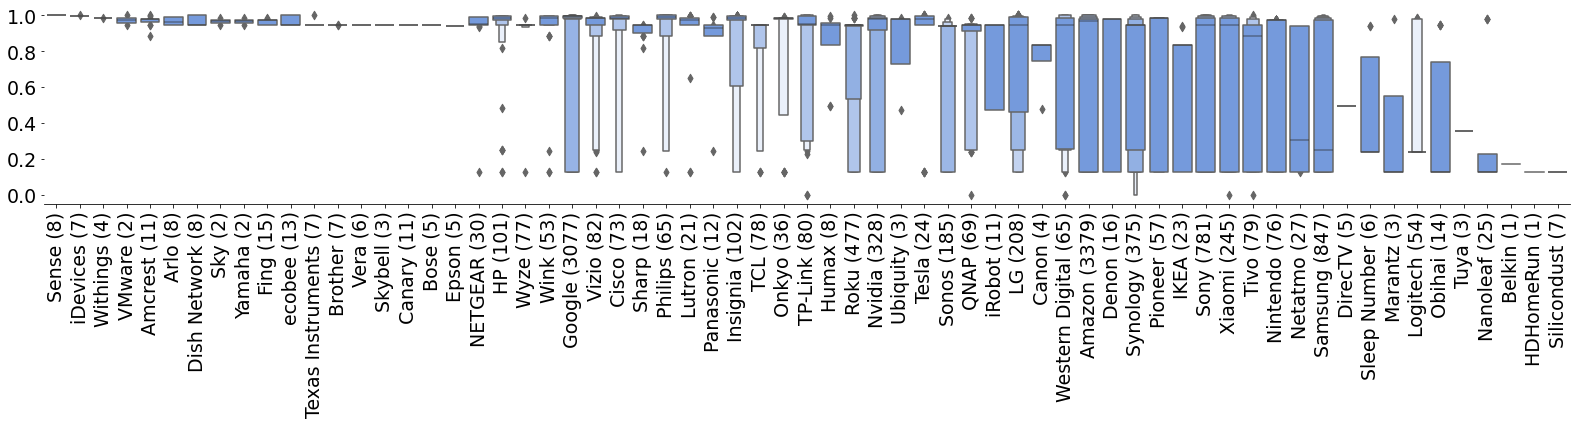

In [48]:
fig = plt.subplots(figsize=(22, 6))
sns.despine(right=True, left=True)

ax = sns.boxenplot(x="device_vendor_withcnt", y="ciphersuites_scoring", data=alldf_withdevcnt, color='cornflowerblue', \
                   scale='linear', showfliers=True, order=position_sorted_mean.index)


#ax.invert_yaxis()
#ax.get_legend().remove()
plt.ylabel("")
plt.xlabel("")
plt.yticks(fontsize=19)
plt.xticks(rotation=90, fontsize=19)

#ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14.5, ha='center', va='top')
#ax.tick_params(axis="y",direction="out", pad=10)
#ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, va='center')

plt.tight_layout()
plt.show()